# Variable statistics

In [1]:
# https://medium.com/intuition/the-principle-of-maximum-entropy-ec5fa2f84a0c

In [2]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'thaumastocoris-peregrinus' #
pseudoabsence = 'random' #'bias-forest' #
training = 'east-asia'
interest = 'south-east-asia'
bioclim = [i for i in range(1,20)] #[1, 5, 6, 12, 13, 14]# [1, 16, 6, 11] #
savefig = True

###########################################################

In [3]:
import os

import numpy as np
import xarray as xr
import rioxarray as rioxr

import pandas as pd
import geopandas as gpd
import elapid as ela
import scipy.stats as stats

import matplotlib.pyplot as plt

In [4]:
def subplot_layout(nplots):

    ncols = min(int(np.ceil(np.sqrt(nplots))), 4)
    nrows = int(np.ceil(nplots / ncols))
    
    return ncols, nrows

In [5]:
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
input_path = os.path.join(out_path, 'input')
output_path = os.path.join(out_path, 'output')

In [6]:
rasters, labels = ['srtm_east-asia.tif', ], ['srtm_elev'] #, 'ndvi_east-asia.tif' , 'ndvi'
for no in bioclim:
    rasters.append('wc2.1_10m_bio_%s_east-asia.tif' %no)
    labels.append('bioclim_%02d' %no)

raster_paths = [os.path.join(input_path, 'train', raster) for raster in rasters]

# initialise dataset
training_data = xr.Dataset()
for raster, label in zip(raster_paths, labels):
    da = rioxr.open_rasterio(raster, masked=True)
    training_data[label] = da


In [21]:
presence_file_name = '%s_presence_%s.csv' %(specie, training)
presence_csv = pd.read_csv(os.path.join(input_path, 'train', presence_file_name))
geometry = gpd.points_from_xy(presence_csv['lon'], presence_csv['lat'])
presence_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

background_file_name = '%s_background_%s_%s.csv' %(specie, pseudoabsence, training)
background_csv = pd.read_csv(os.path.join(input_path, 'train', background_file_name))
geometry = gpd.points_from_xy(background_csv['lon'], background_csv['lat'])
background_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

presence_train = ela.annotate(
    presence_gdf.geometry,
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
    quiet=True
)

background_train = ela.annotate(
    background_gdf, #pseudoabsence_random, pseudoabsence_bias_eucalyptus, #pseudoabsence_bias_perc_planted
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
    quiet=True
)

/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/elapid/geo.py:468: RuntimeWarning: invalid value encountered in cast
  samples = np.array(samples_iter, dtype=dtype)
/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/elapid/geo.py:468: RuntimeWarning: invalid value encountered in cast
  samples = np.array(samples_iter, dtype=dtype)


### 3.1 Probability density plot

In [22]:
var_data = {}

nbins = 100
for name in ['bioclim_01', 'bioclim_12']:
    var = background_train[name]

    dx = (var.max() - var.min()) / nbins
    bins = np.linspace(var.min() - 10*dx, var.max() + 10*dx, nbins)
    
    fit = stats.maxwell.fit(var)
    pdf = stats.maxwell.pdf(bins, *fit)
    
    var_data[name] = {}
    var_data[name]['bins'] = bins
    var_data[name]['pdf'] = pdf
    var_data[name]['long_name'] = training_data[name].attrs['long_name']


In [23]:
# x, y = np.meshgrid(var_data['bioclim_01']['bins'], var_data['bioclim_12']['bins'])
# pos = np.dstack((x, y))


# idx = np.argmax(var_data['bioclim_12']['pdf'])

# rv = multivariate_t([var_data['bioclim_01']['bins'][np.argmax(var_data['bioclim_01']['pdf'])], 
#                      var_data['bioclim_12']['bins'][np.argmax(var_data['bioclim_12']['pdf'])]], 
#                     [[.5, .5], [0.1,1000]], df=2)


In [24]:
# fig, ax = plt.subplots(1, 1)
# plt.contourf(x, y, rv.pdf(pos))

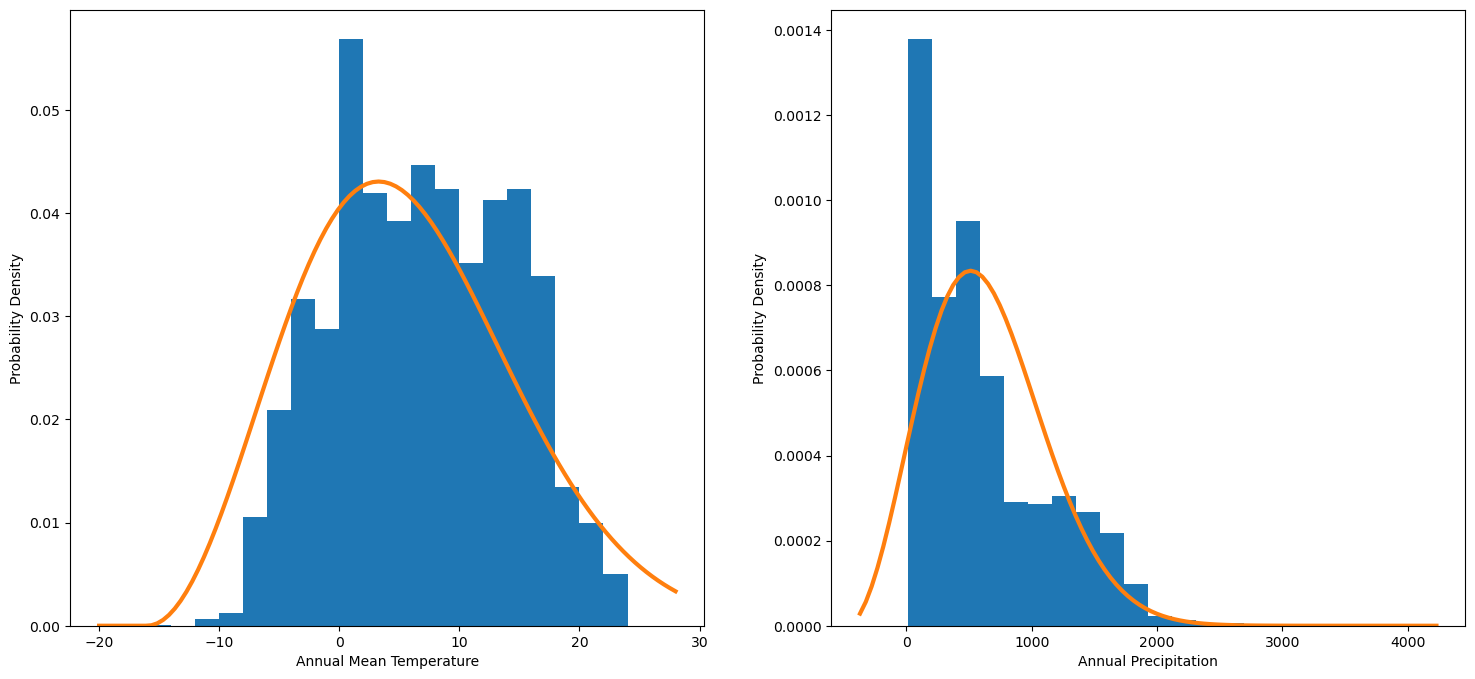

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))

background_train['bioclim_01'].plot.hist(ax=ax[0], bins=20, density=True)
ax[0].plot(var_data['bioclim_01']['bins'], var_data['bioclim_01']['pdf'], lw=3, label='maxwell pdf')
ax[0].set_xlabel(var_data['bioclim_01']['long_name'])

background_train['bioclim_12'].plot.hist(ax=ax[1], bins=20, density=True)
ax[1].plot(var_data['bioclim_12']['bins'], var_data['bioclim_12']['pdf'], lw=3, label='maxwell pdf')
ax[1].set_xlabel(var_data['bioclim_12']['long_name'])

for iax in ax:
    iax.set_ylabel('Probability Density')

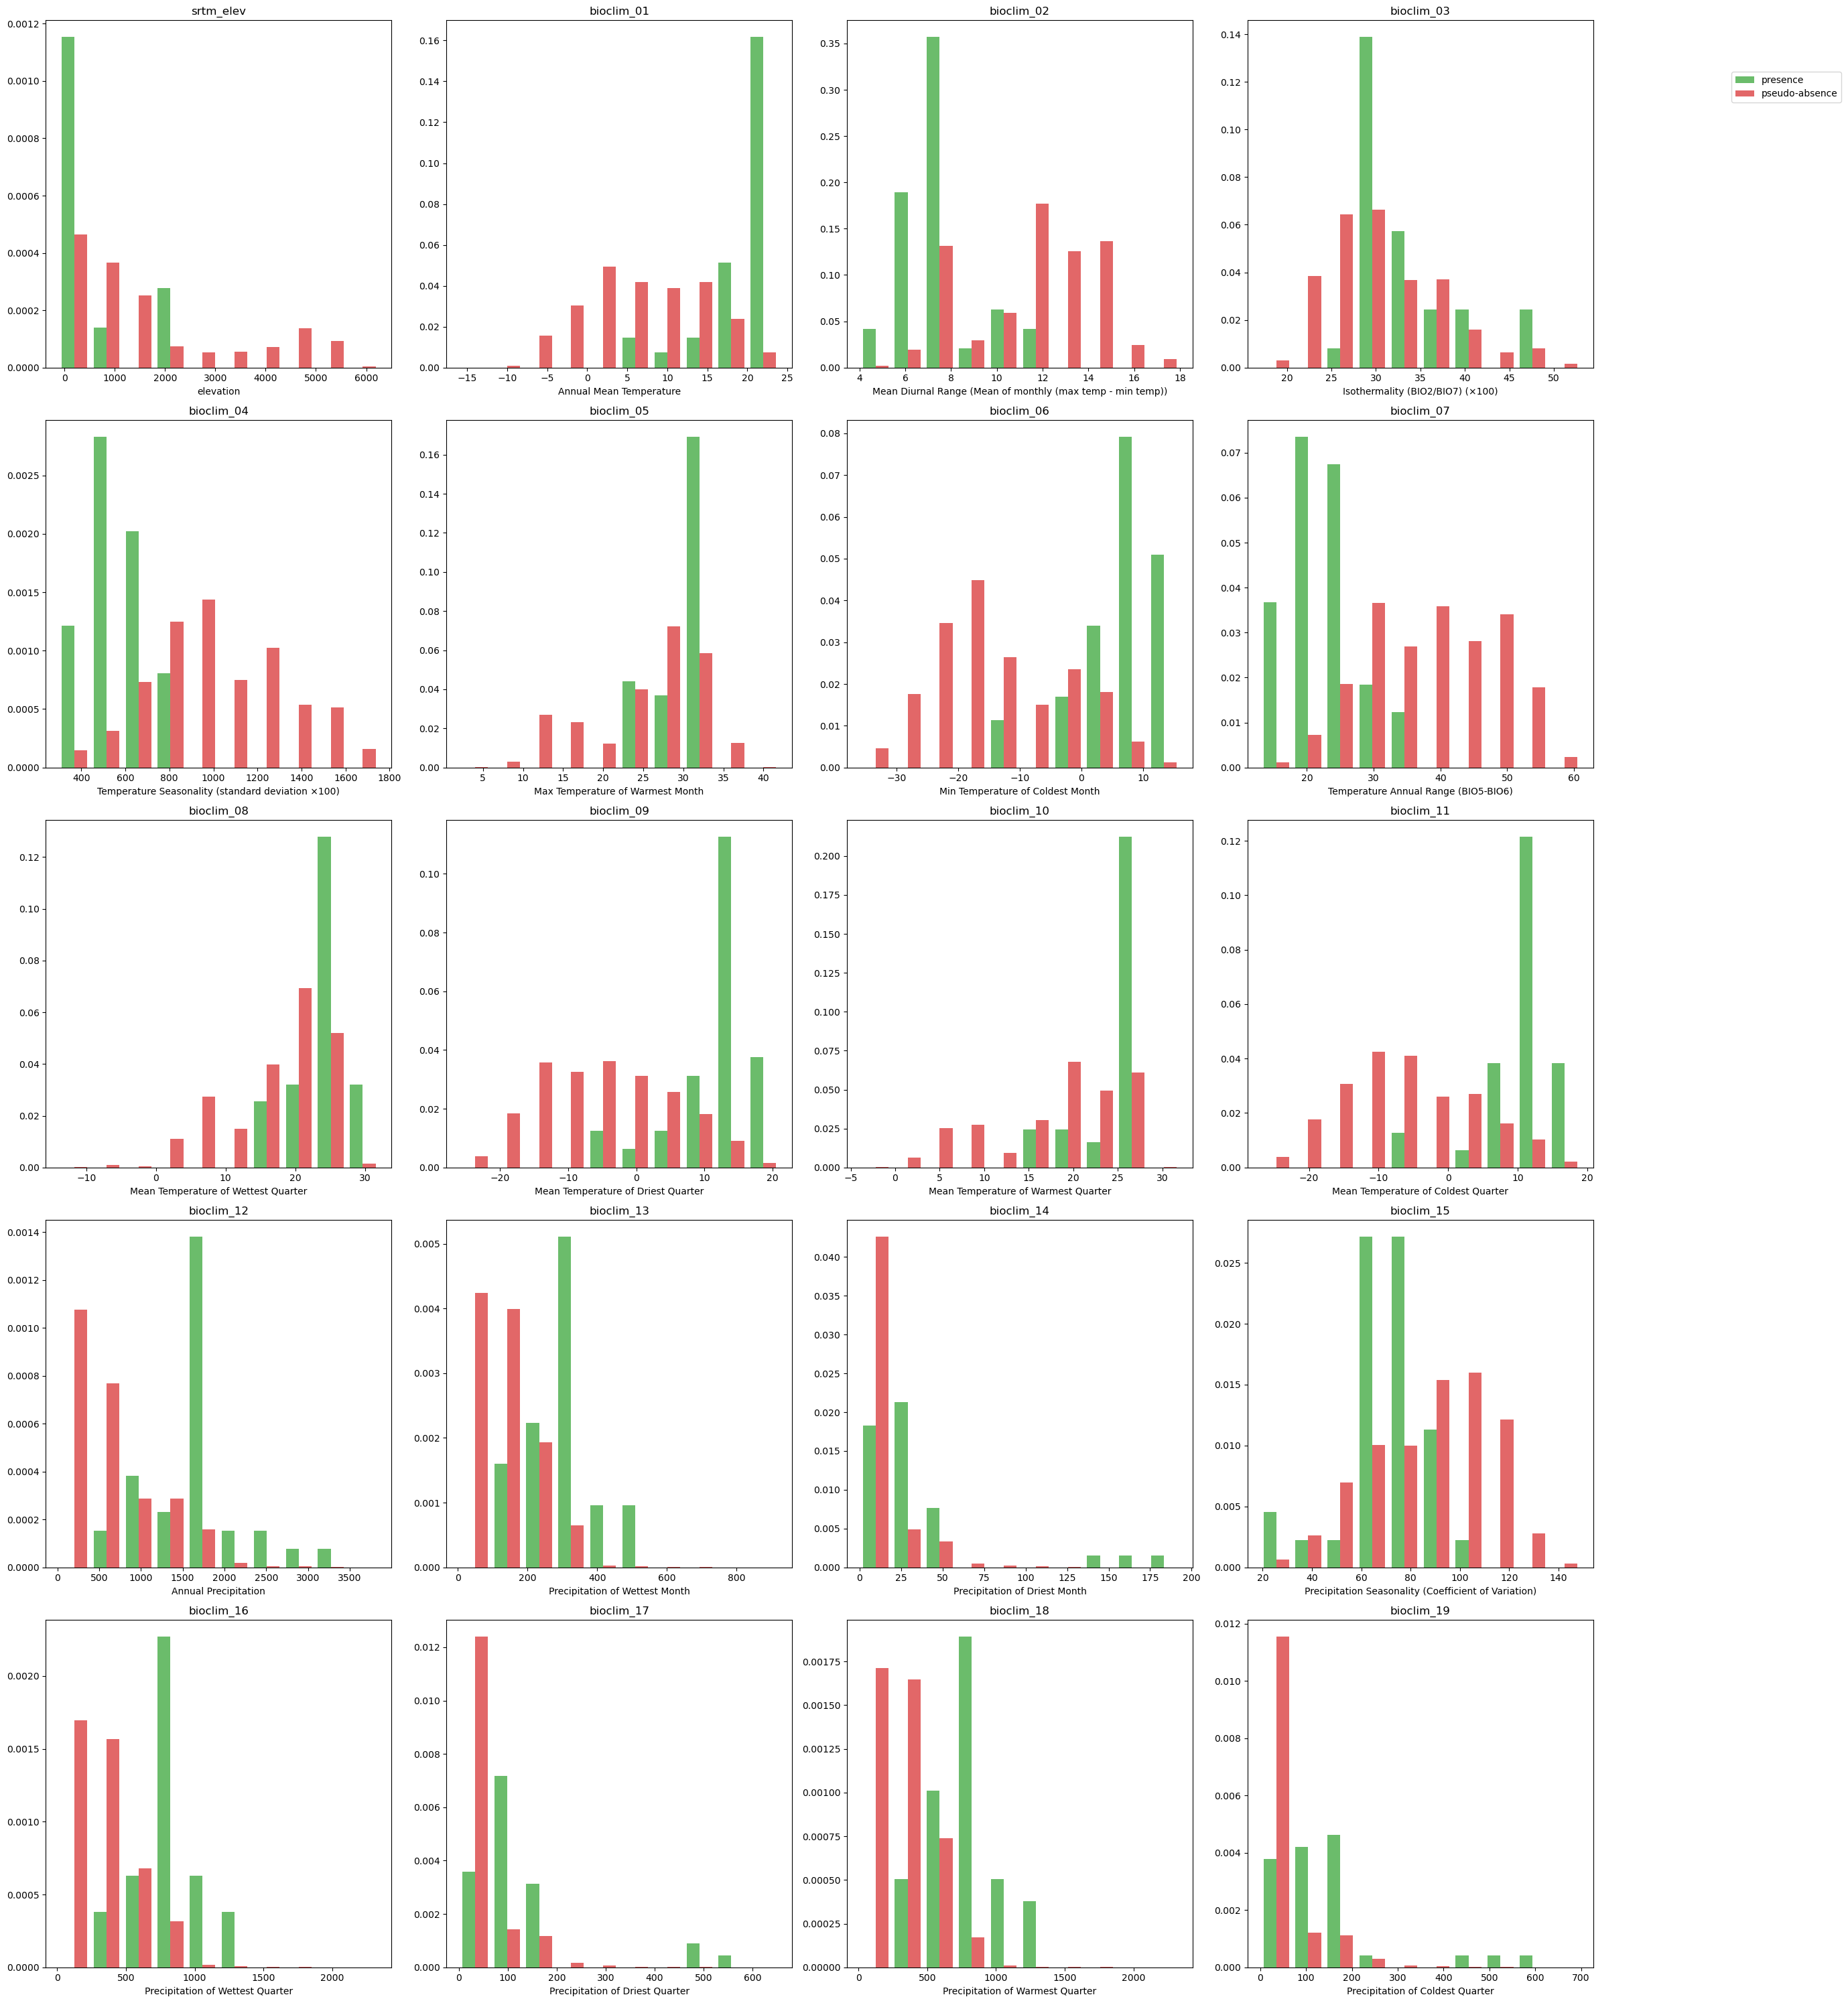

In [27]:
pair_colors = ['tab:green', 'tab:red']
ncols, nrows = subplot_layout(len(labels))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6))
if (nrows, ncols) == (1, 1):
    ax = [axs]
else:
    ax = axs.ravel()

xlabels = list(training_data.data_vars.keys())
for iax, label in enumerate(labels):
    pvar = presence_train[label]
    
    bvar = background_train[label]
    ax[iax].hist(
        [pvar, bvar],
        density=True,
        alpha=0.7,
        label=['presence', 'pseudo-absence'],
        color=pair_colors,
    )
    ax[iax].set_title(label)
    try:
        ax[iax].set_xlabel(training_data[xlabels[iax]].long_name)
    except AttributeError:
        ax[iax].set_xlabel('No variable long_name')
    
handles, lbls = ax[iax].get_legend_handles_labels()
fig.legend(handles, lbls, loc='upper right', bbox_to_anchor=(1.15, 0.965))
plt.tight_layout()

# # turn off empty plots
for axi in ax:
    if not axi.title.get_text():
        axi.set_visible(False)

## 1. Variable correlation matrix

(!) move this maybe to script 5 variable importance?

In [12]:
# ds = xr.merge([bioclim, srtm_region])

In [12]:
df = training_data.isel(band=0).reset_coords(['band', 'spatial_ref'], drop=True).to_dataframe()
correlation_matrix = df.corr(method='spearman')

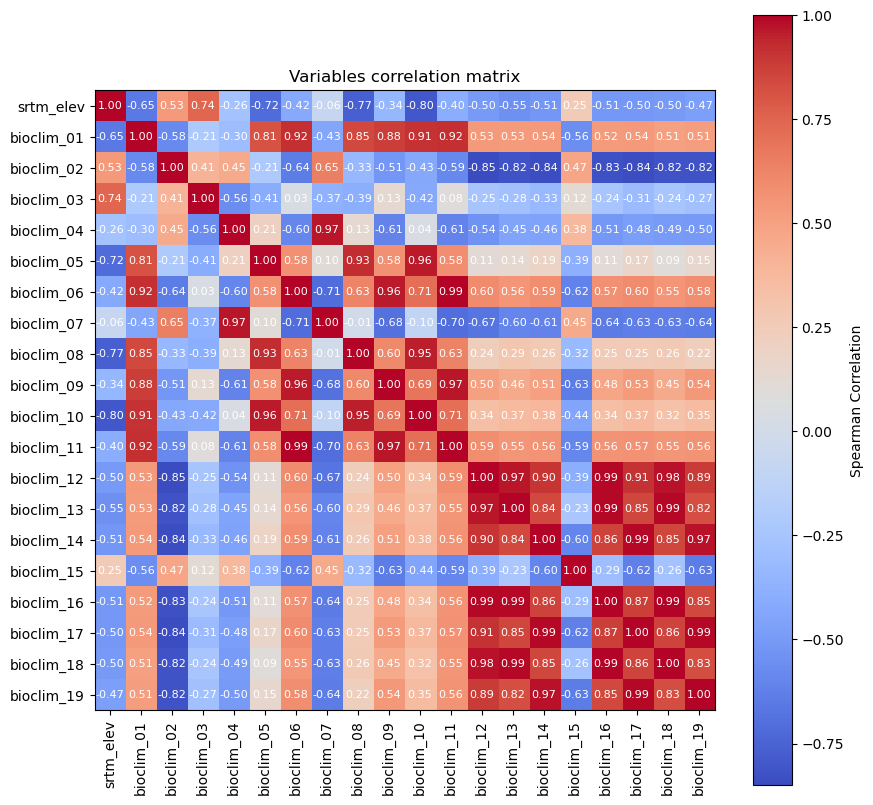

In [13]:
plt.figure(figsize=(10,10))

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Display Numerical Values on Heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center', color='white', fontsize=8)

columns = df.columns.tolist()
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns)
plt.title("Variables correlation matrix")
plt.colorbar(label="Spearman Correlation")
# plt.savefig('correlation_heatmap_plot.png')
plt.show()

In [11]:
# https://github.com/osgeokr/pySDM-geemap/blob/main/pySDM-geemap_Case%20Study%201_Pitta%20nympha.ipynb
# https://github.com/dennisbakhuis/Tutorials/blob/master/3_Covariance_PCA/Principle%20component%20analysis%20and%20the%20covariance%20matrix.ipynb
# https://www.geeksforgeeks.org/exploring-correlation-in-python/

TODO (!): variable importance plot for both training and test data